# Swish-based dense split ensemble with categorical entity embedding
- Full split between PRI and DER features
- PRI_jet_num embedded
- Train-time/test-time data augmentation
- Onecycle
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
NAME = '14_swish_ensemble_embed_aug_onecycle_dense_split'

In [4]:
experiment = Experiment(NAME, 'helios_cuda', RESULTS_PATH)

In [5]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s {experiment.seed}

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_sub

## Training

### Import data

In [6]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [7]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


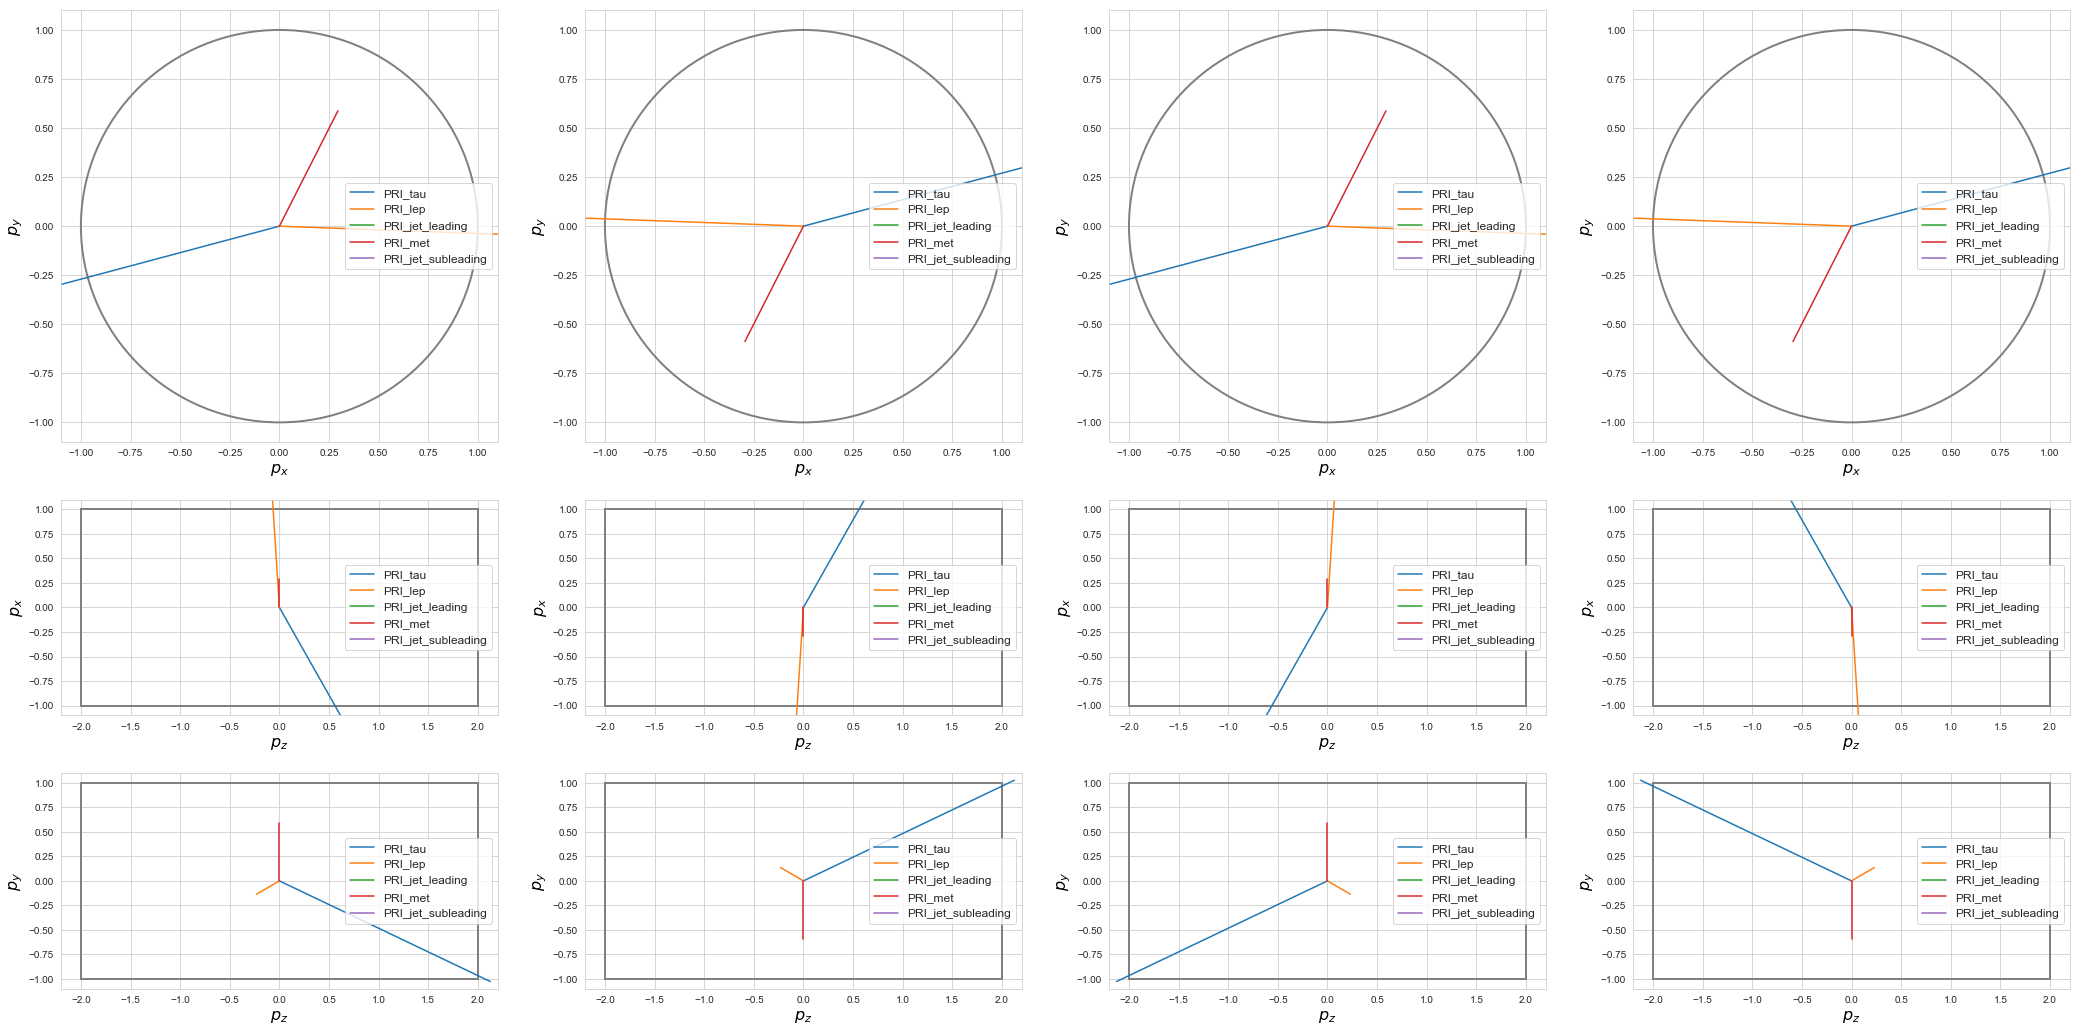

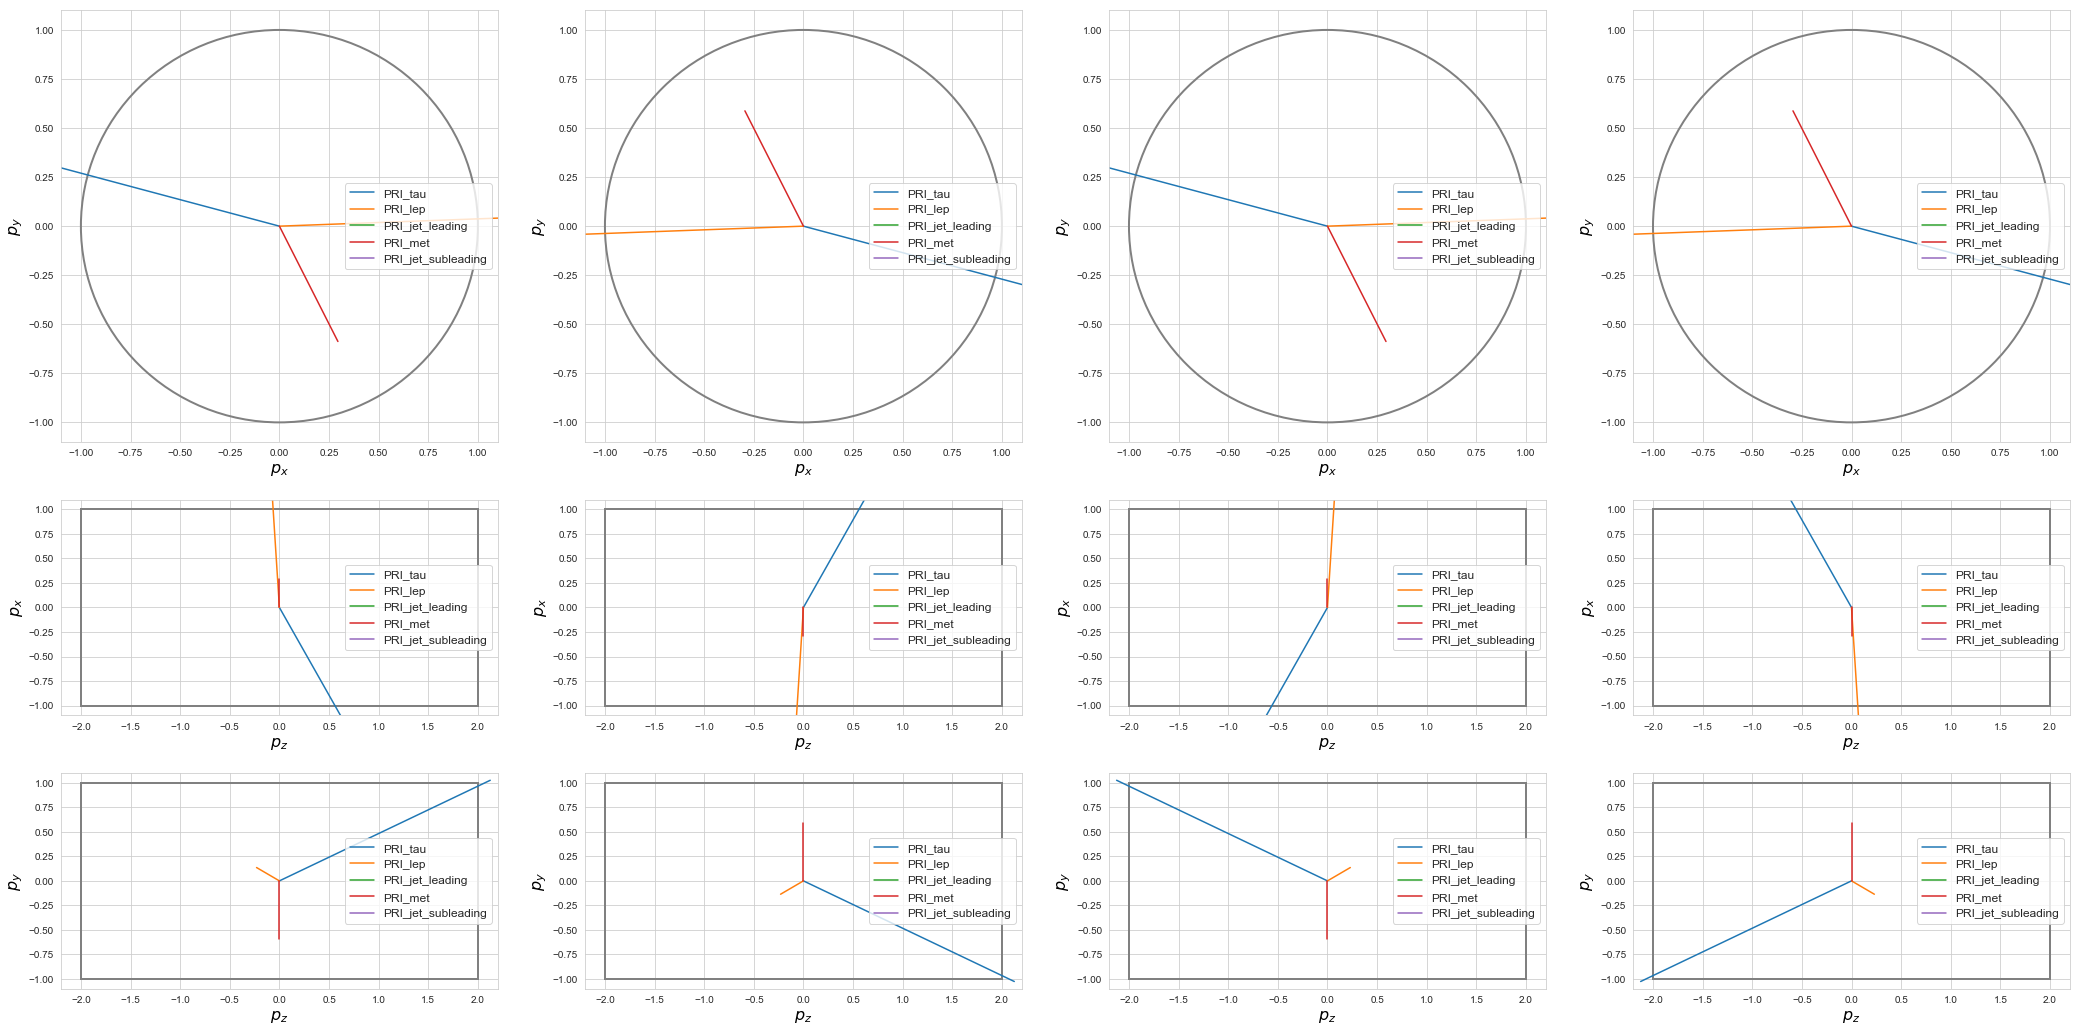

In [8]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


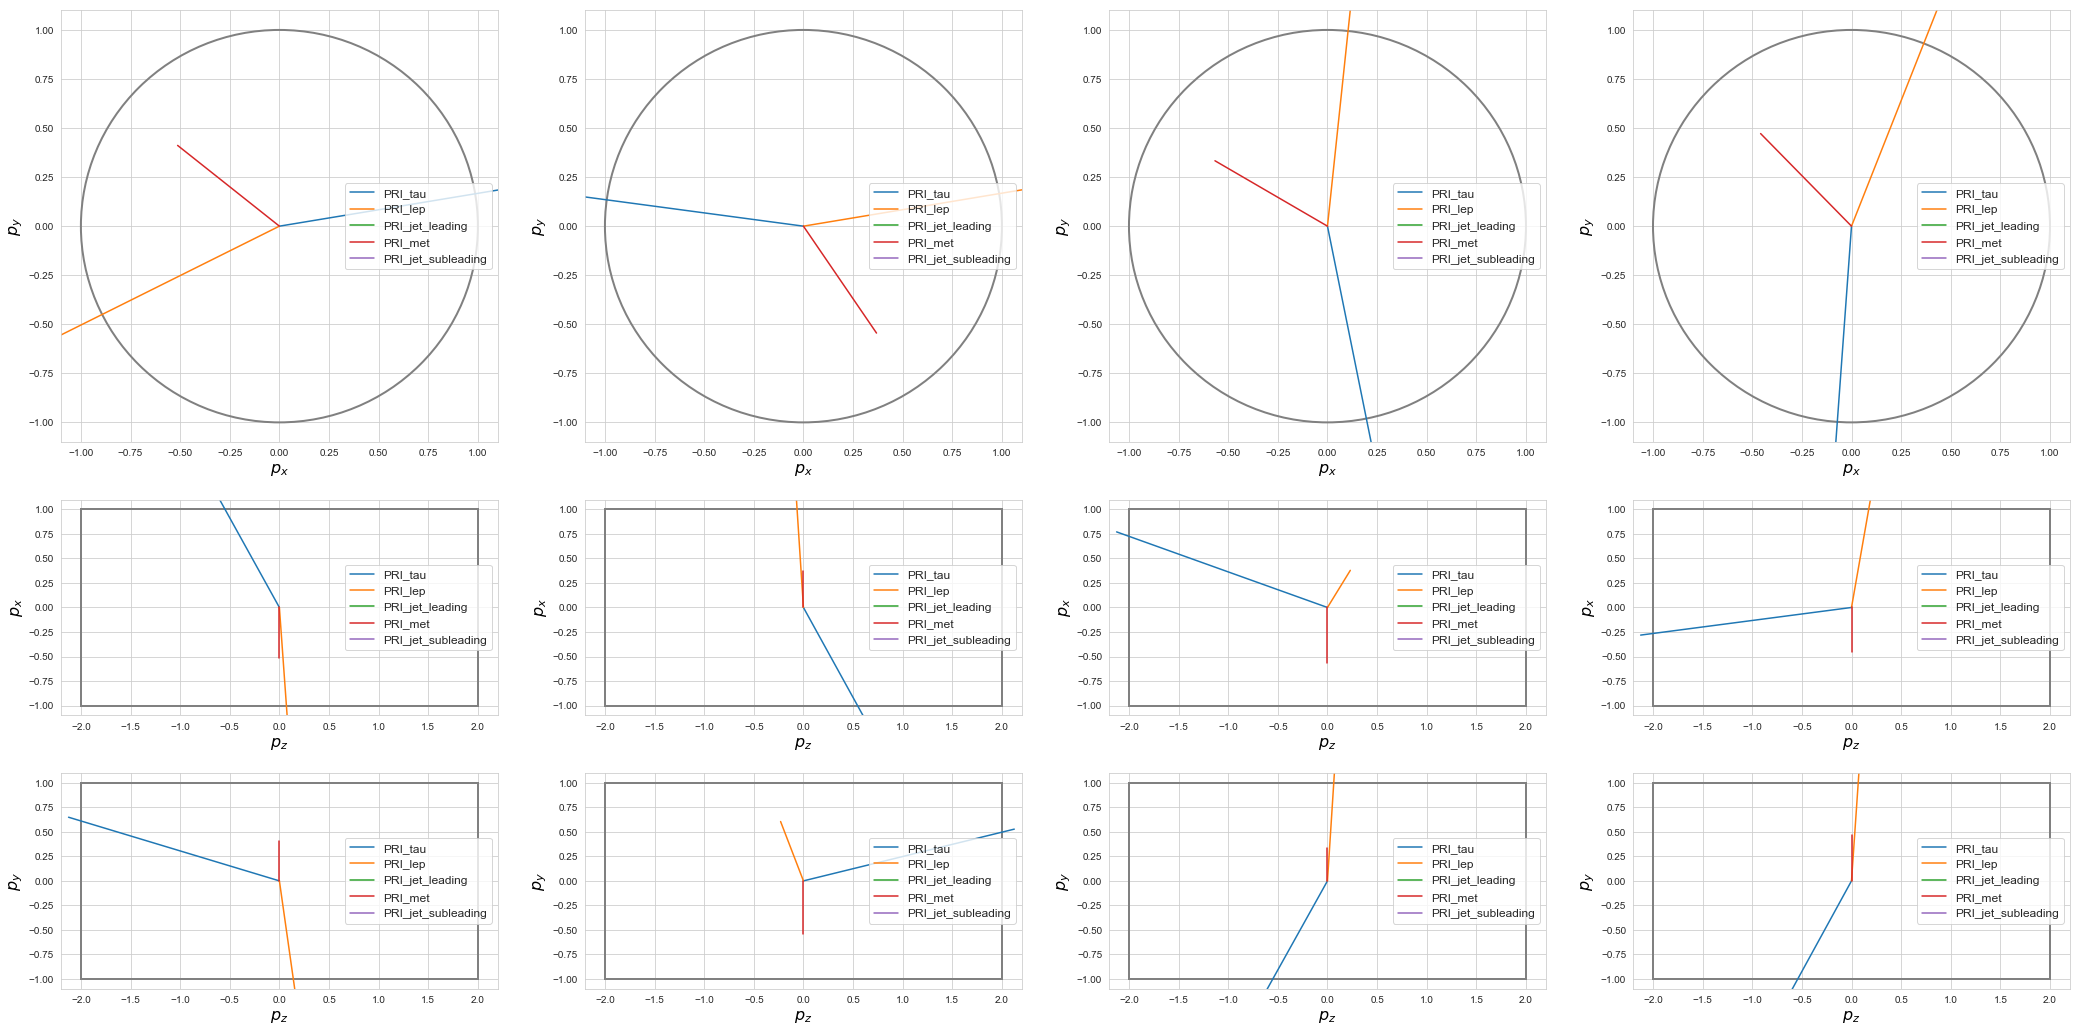

In [9]:
id=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1] for i in range(4)])

### Options

In [10]:
n_models = 10
patience = 50
max_epochs = 15
ensemble_size = 10

bs = 256
objective = 'classification'
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])

hl_feats = [f for f in train_feats if 'DER_' in f]
ll_feats = [f for f in train_feats if 'PRI_' in f]
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=len(ll_feats)+2, act='swish', dense=True)],
               feats_per_block=[hl_feats, ll_feats])

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             body=body, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): Sequential(
          (0): Sequential(
            (0): Linear(i

### Determine LR

LR finder took 5.226s 


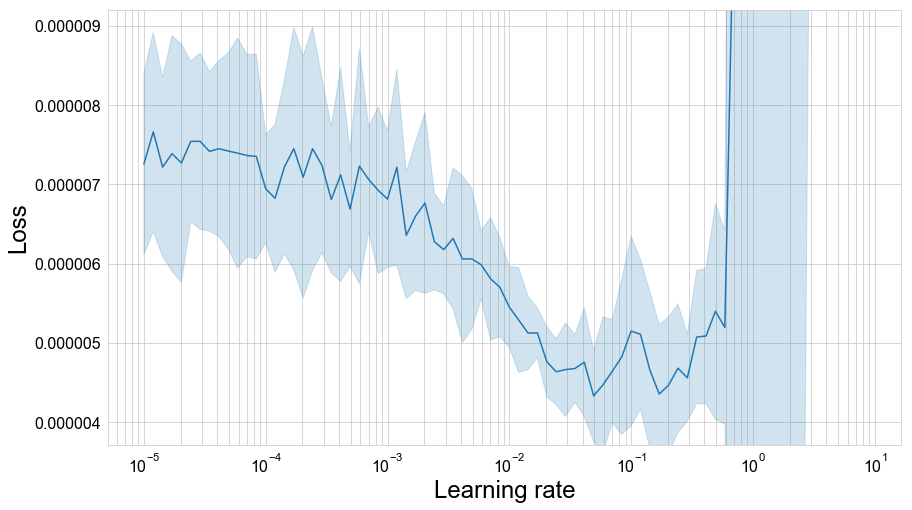

In [11]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [12]:
callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2], mom_range=(0.85, 0.95), interp='cosine')]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}

Training model 1 / 10, Val ID = 0


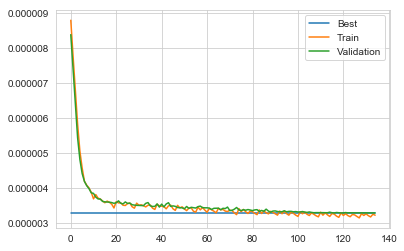

Early stopping after 135 epochs
Scores are: {'loss': 3.3002761483658105e-06, 'AMS': 3.5897369485490045}
Fold took 75.239s

Training model 2 / 10, Val ID = 1


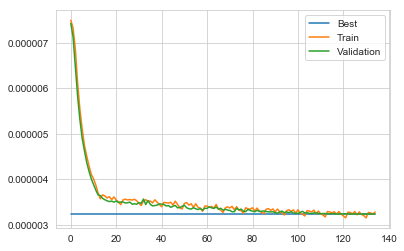

Early stopping after 135 epochs
Scores are: {'loss': 3.2363739137508674e-06, 'AMS': 3.6231177870927174}
Fold took 75.191s

Training model 3 / 10, Val ID = 2


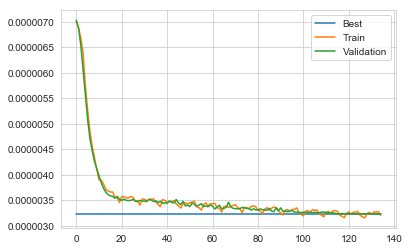

Early stopping after 135 epochs
Scores are: {'loss': 3.2367745461669983e-06, 'AMS': 3.7787525776229547}
Fold took 76.297s

Training model 4 / 10, Val ID = 3


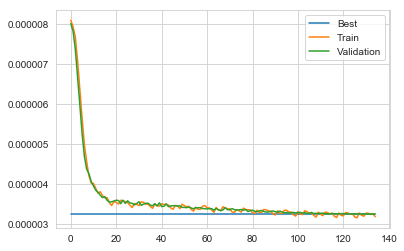

Early stopping after 135 epochs
Scores are: {'loss': 3.2582227049715584e-06, 'AMS': 3.6900801175289493}
Fold took 74.618s

Training model 5 / 10, Val ID = 4


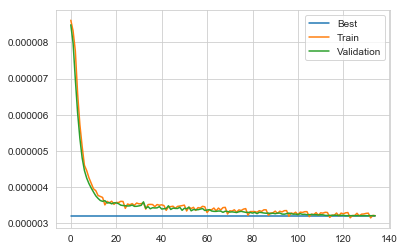

Early stopping after 135 epochs
Scores are: {'loss': 3.213657464584685e-06, 'AMS': 3.5401538986875893}
Fold took 75.248s

Training model 6 / 10, Val ID = 5


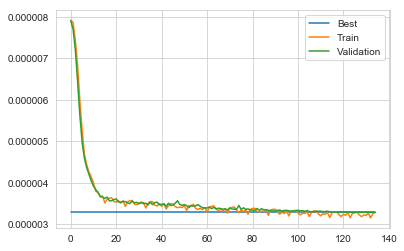

Early stopping after 135 epochs
Scores are: {'loss': 3.2890523016249062e-06, 'AMS': 3.8899854579063673}
Fold took 75.357s

Training model 7 / 10, Val ID = 6


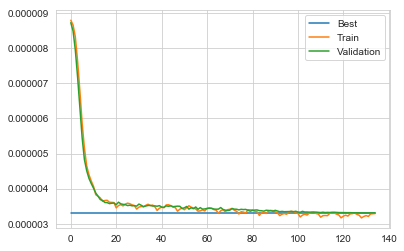

Early stopping after 135 epochs
Scores are: {'loss': 3.3086594157794025e-06, 'AMS': 3.6220367531312223}
Fold took 75.982s

Training model 8 / 10, Val ID = 7


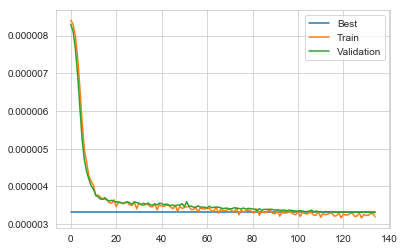

Early stopping after 135 epochs
Scores are: {'loss': 3.3116921258624643e-06, 'AMS': 3.4735973885106555}
Fold took 75.078s

Training model 9 / 10, Val ID = 8


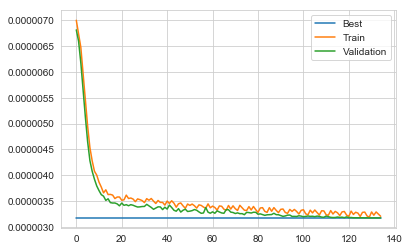

Early stopping after 135 epochs
Scores are: {'loss': 3.1759027478983626e-06, 'AMS': 4.146419124911368}
Fold took 75.767s

Training model 10 / 10, Val ID = 9


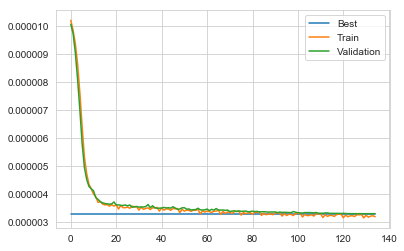

Early stopping after 135 epochs
Scores are: {'loss': 3.3037547382264165e-06, 'AMS': 3.3568644549746858}
Fold took 75.821s


______________________________________
Training finished
Cross-validation took 754.601s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

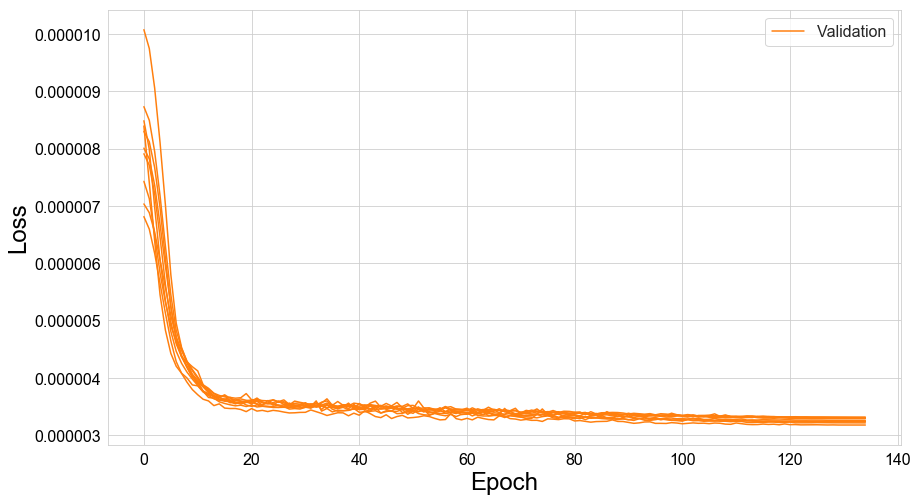

Mean loss = 3.26e-06±1e-08
Mean AMS = 3.67±0.07
______________________________________



In [13]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [14]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [15]:
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 8 with loss = 3.1759027478983626e-06
Model 1 is 4 with loss = 3.213657464584685e-06
Model 2 is 1 with loss = 3.2363739137508674e-06
Model 3 is 2 with loss = 3.2367745461669983e-06
Model 4 is 3 with loss = 3.2582227049715584e-06
Model 5 is 5 with loss = 3.2890523016249062e-06
Model 6 is 0 with loss = 3.3002761483658105e-06
Model 7 is 9 with loss = 3.3037547382264165e-06
Model 8 is 6 with loss = 3.3086594157794025e-06
Model 9 is 7 with loss = 3.3116921258624643e-06


### Interpretation

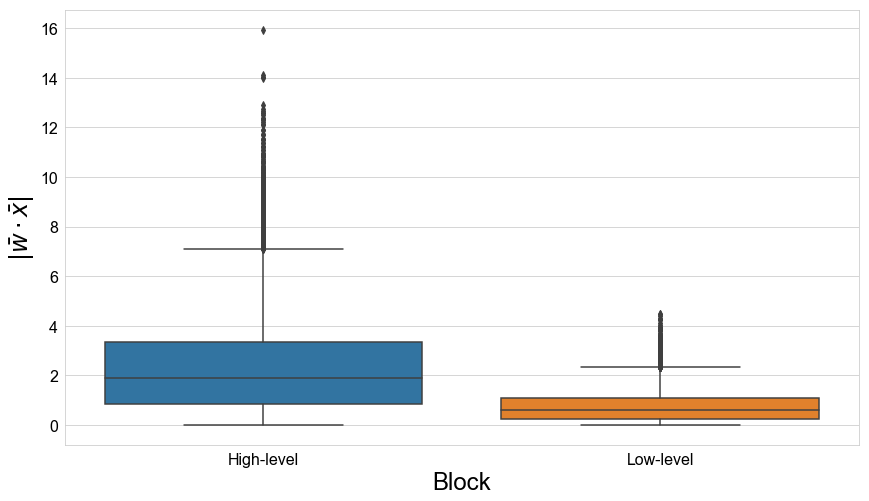

In [16]:
plot_multibody_weighted_outputs(ensemble[0][1], train_fy[2]['inputs'], ['High-level', 'Low-level'], savename='wide_deep_hl_ll', settings=plot_settings)

### Validation

#### Response on validation data without TTA

In [17]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [18]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time_no_tta'] = val_time

Mean time per event = 3.39e-06±1e-07


In [19]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.933786928653717 corresponds to AMS of 3.433283629312225
Maximum AMS for data is 3.4425438413254437 at cut of 0.9335047006607056


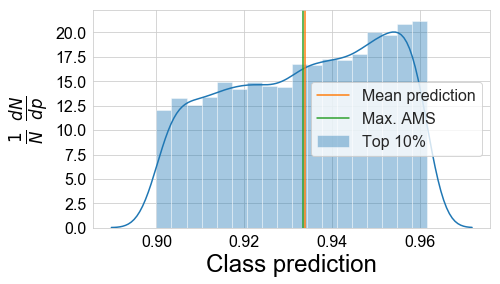

In [20]:
cut, experiment['val_ams_smooth_no_tta'], experiment['val_ams_max_no_tta'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

#### Response on validation data with TTA

In [21]:
val_fy = HEPAugFoldYielder(DATA_PATH/'val.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [22]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy, pred_name='pred_tta')
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 8.95e-05±2e-07


In [23]:
val_df = val_fy.get_df(pred_name='pred_tta')

50000 datapoints loaded


Mean cut at 0.9337189197540283 corresponds to AMS of 3.409507535735025
Maximum AMS for data is 3.4201426629978484 at cut of 0.9346081614494324


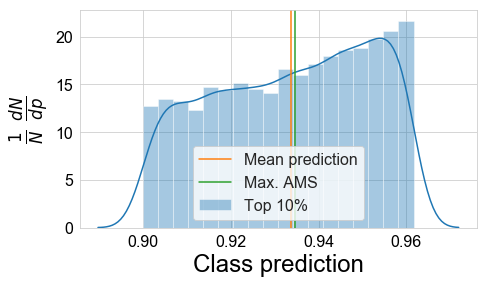

In [24]:
cut_tta, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring without TTA

In [25]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [26]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time_no_tta'] = test_time

Mean time per event = 9.4e-07±2e-08


In [27]:
experiment['test_public_ams_mean_no_tta'], experiment['test_private_ams_mean_no_tta'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.55±0.08 : 3.55±0.03


In [28]:
experiment['test_public_ams_no_tta'], experiment['test_private_ams_no_tta'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.5319425905997175 : 3.5510855883903925


#### Test scoring with TTA

In [29]:
test_fy = HEPAugFoldYielder(DATA_PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [30]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy, pred_name='pred_tta')
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 3.354e-05±9e-08


In [31]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut_tta, pred_name='pred_tta')

Mean Public:Private AMS: 3.57±0.08 : 3.55±0.03


In [32]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut_tta, pred_name='pred_tta')

Public:Private AMS: 3.550572523765278 : 3.548350561609227


## Results 

In [33]:
experiment

Experiment:	14_swish_ensemble_embed_aug_onecycle_dense_split
Machine:	helios_cuda
Device:	Nvidia GeForce GTX 1080 Ti GPU
train_time	754.9714556990002
val_time_no_tta	0.17591423300109454
val_ams_smooth_no_tta	3.433283629312225
val_ams_max_no_tta	3.4425438413254437
val_time	4.482314716002293
val_ams_smooth	3.409507535735025
val_ams_max	3.4201426629978484
test_time_no_tta	0.5276368869999715
test_public_ams_mean_no_tta	(3.551482268049201, 0.08095699251672422)
test_private_ams_mean_no_tta	(3.5540558316928603, 0.029525803883818466)
test_public_ams_no_tta	3.5319425905997175
test_private_ams_no_tta	3.5510855883903925
test_time	18.458457794000424
test_public_ams_mean	(3.5674936919651814, 0.0760382776385409)
test_private_ams_mean	(3.551484971552548, 0.029884086394414762)
test_public_ams	3.550572523765278
test_private_ams	3.548350561609227

In [34]:
experiment.save()